In [2]:
from cil.framework import  AcquisitionGeometry
from cil.optimisation.algorithms import Algorithm
from cil.optimisation.functions import IndicatorBox, LeastSquares, BlockFunction
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D
import matplotlib.pyplot as plt
import numpy as np
import sys
cil_path = '/home/user/CILworkspace/CIL/'
fun_path = 'Wrappers/Python/cil/optimisation/functions'
sys.path.append(cil_path + fun_path)

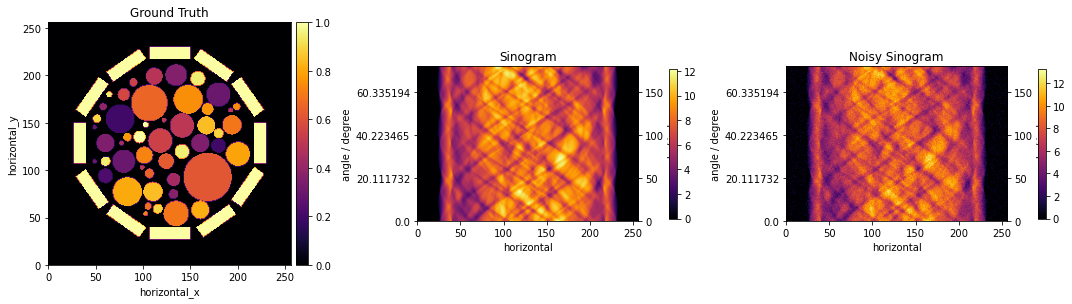

In [3]:
# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device='gpu')

# Create an acqusition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
noise_scale = 1

gaussian_var = 0.5 * noise_scale
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size=ag.shape)

noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array < 0] = 0

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], title=['Ground Truth', 'Sinogram', 'Noisy Sinogram'], num_cols=3, cmap='inferno')

Initialised GradientOperator with C backend running with  16  threads
SPDHG setting up
SPDHG configured


/home/user/miniconda/lib/python3.6/site-packages/cil/framework/framework.py:2363: RuntimeWarning: invalid value encountered in true_divide
  out = pwop(self.as_array() , x2.as_array() , *args, **kwargs )


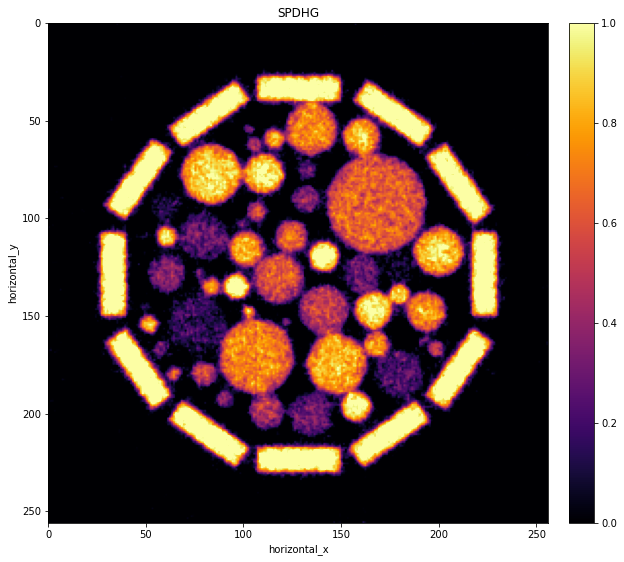

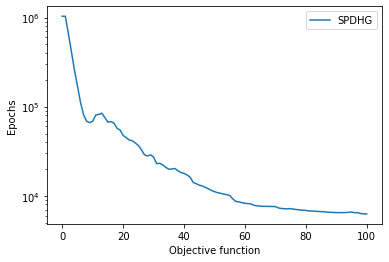

In [4]:
from cil.optimisation.algorithms.SPDHG import SPDHG
from cil.processors import Slicer
from cil.optimisation.functions import MixedL21Norm, BlockFunction, L2NormSquared
from cil.optimisation.operators import GradientOperator, BlockOperator

Grad1 = GradientOperator(ig, correlation='SpaceChannels')


# Define number of subsets
n_subsets = 10

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# Define F_i's and A_i's
for i in range(n_subsets):
    # Total number of angles
    n_angles = len(ag.angles)
    # Divide the data into subsets
    data_subset = Slicer(roi = {'angle' : (i,n_angles,n_subsets)})(noisy_sino)

    # Define A_i and put into list 
    ageom_subset = data_subset.geometry
    Ai = ProjectionOperator(ig, ageom_subset)
    A_subsets.append(Ai)

    # Define F_i and put into list
    fi = 0.5*L2NormSquared(b = data_subset)
    f_subsets.append(fi)

alpha =1e-10

# Define F and K
K = BlockOperator(*A_subsets, Grad1)
F = BlockFunction(*f_subsets, alpha*MixedL21Norm())

# SPDHG
num_epochs = 100
initial = ig.allocate(0)

g = IndicatorBox(lower=0)
spdhg = SPDHG(operator=K, f=F, g=g, update_objective_interval=1,max_iteration=1000)
spdhg.run(num_epochs, verbose=0)

show2D([spdhg.solution],
       title=["SPDHG"],
       origin="upper",
       fix_range=(0,1), num_cols=2,
       cmap='inferno')

plt.figure()
plt.semilogy(spdhg.objective, label="SPDHG")

plt.legend()
plt.ylabel('Epochs')
plt.xlabel('Objective function')
plt.show()
np.save("SPDHG.npy",spdhg.objective)